In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Selection and Pipeline Overview

Choose your dataset and update the corresponding dataloader, model, and loss as needed. Typical configurations:

- **Blobs Dataset:**  
  `BlobsDataset("../data/blobs.csv")`  
  Model: `disc_model.load("../models/BlobsDataset/...")`  
  Target size: 3  
  Loss: `MulticlassDiscLoss`

- **Moons Dataset:**  
  `MoonsDataset("../data/moons.csv")`  
  Model: `disc_model.load("../models/MoonsDataset/...")`  
  Target size: 1  
  Loss: `BinaryDiscLoss`

- **MoonsWithBlob Dataset:**  
  `MoonsWithBlobDataset("../data/moons_with_blob.csv")`  
  Model: `disc_model.fit(...)`  
  Target size: 3  
  Loss: `MulticlassDiscLoss`

> **Tip:** Avoid renaming imports with "F2" to prevent breaking dataset class definitions.


In [25]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import MoonsWithBlobDataset
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics import evaluate_cf

In [26]:
dataset = MoonsWithBlobDataset("../data/moons_with_blob.csv") # /blobs.csv, /moons.csv, moons_with_blob.csv
train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

### Visualizing the Dataset

Plot the training and test data to understand the distribution and class separation.

X shape: torch.Size([800, 2])
y shape: torch.Size([800])


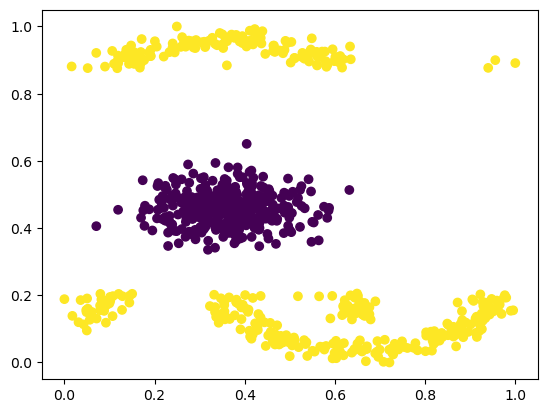

In [27]:
for X, y in train_dataloader:
    print(f"X shape: {X.shape}") 
    print(f"y shape: {y.shape}") 
    plt.scatter(X[:, 0], X[:, 1], c=y)

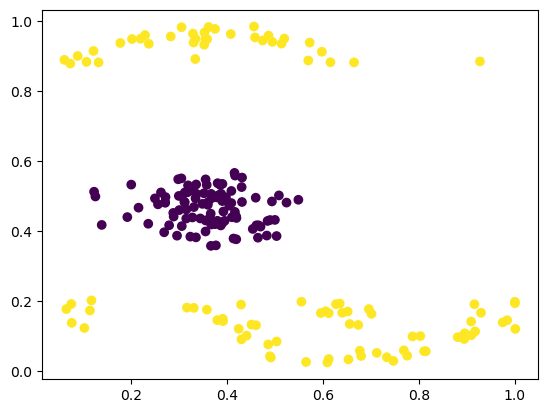

In [28]:
for X, y in test_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

### Training the Discriminative Model

Set up and train the classifier for the selected dataset.

In [29]:
train_dataloader = dataset.train_dataloader(batch_size=128, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
disc_model.fit(
    train_dataloader,
    test_dataloader,
    epochs=5000,
    patience=300,
    lr=1e-3,
)
# disc_model.load("../models/BlobsDataset/disc_model_MultilayerPerceptron.pt")


Epoch 749, Train: 0.0047, test: 0.0044, patience: 300:  15%|█▌        | 750/5000 [00:08<00:46, 91.81it/s] 


### Visualise results

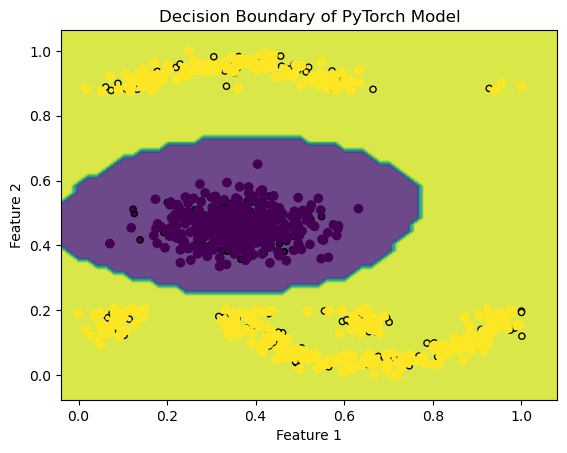

In [30]:
import numpy as np

# Create a mesh grid for plotting decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the grid points
disc_model.eval()
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = disc_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary of PyTorch Model")

for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

### Prepare PPCEF pieline

In [31]:
# Train the Masked Autoregressive Flow model
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1], hidden_features=8, context_features=1
)
gen_train_dataloader = dataset.train_dataloader(
    batch_size=1024, shuffle=True, noise_lvl=0.03
)
gen_model.fit(train_dataloader, test_dataloader, num_epochs=1000)

Epoch 224, Train: -1.8733, test: -1.8258, patience: 20:  22%|██▏       | 224/1000 [00:05<00:17, 44.74it/s]


In [32]:
### Setting Up the PPCEF Pipelinenerative and discriminative models

cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)
cf_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)
log_prob_threshold = torch.quantile(gen_model.predict_log_prob(cf_dataloader), 0.25)

deltas, X_orig, y_orig, y_target, logs = cf.explain_dataloader(
    cf_dataloader, alpha=100, log_prob_threshold=log_prob_threshold, epochs=4000
)

  0%|          | 0/4000 [00:00<?, ?it/s]

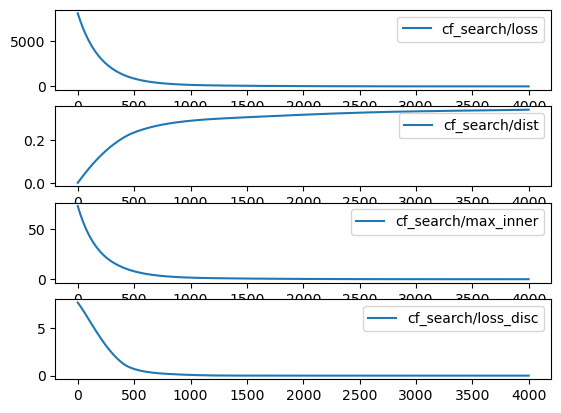

In [33]:
for i, (log_name, log_vals) in enumerate(logs.items()):
    plt.subplot(len(logs), 1, i + 1)
    plt.plot(log_vals, label=log_name)
    plt.legend()

In [34]:
X_cf = X_orig + deltas

### Generating Counterfactuals

Compute counterfactual examples for the original data.

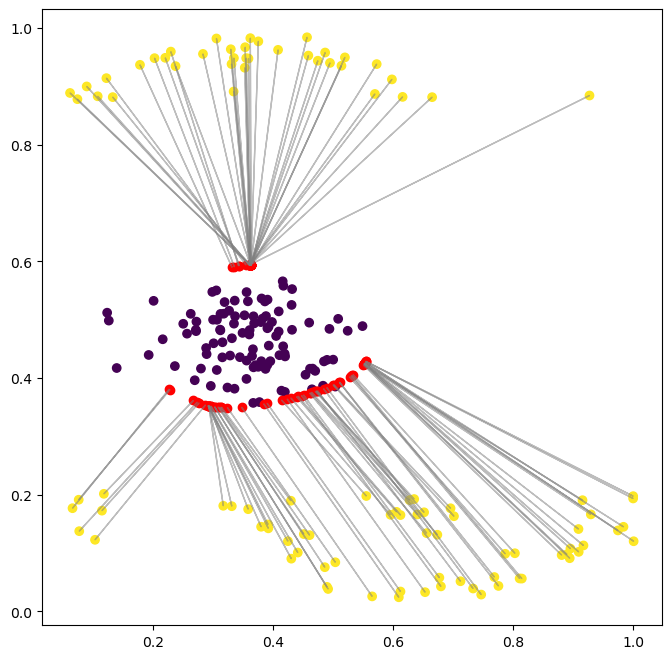

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

i = y_orig.reshape(-1) == 1
ax.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig)
ax.scatter(X_orig[i, 0] + deltas[i, 0], X_orig[i, 1] + deltas[i, 1], c="r")
for before, after in zip(X_orig[i], X_cf[i]):
    ax.arrow(
        before[0],
        before[1],
        after[0] - before[0],
        after[1] - before[1],
        head_width=0.0,
        head_length=0.0,
        fc="gray",
        ec="gray",
        alpha=0.5,
        width=0.0001,
    )

### Visualizing Counterfactuals

Plot the original and counterfactual points to illustrate the changes suggested by the model.

In [36]:
evaluate_cf(
    disc_model=disc_model,
    gen_model=gen_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]),
    continuous_features=dataset.numerical_features,
    categorical_features=dataset.categorical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_orig,
    y_test=y_orig,
    median_log_prob=log_prob_threshold,
    y_target=y_target,
)

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.3401605021332397,
 'proximity_continuous_manhattan': 0.4566614901740104,
 'proximity_continuous_euclidean': 0.3401605021332397,
 'proximity_continuous_mad': 2.9680091685056684,
 'proximity_l2_jaccard': 0.3401605021332397,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.955,
 'log_density_cf': 1.1591054,
 'log_density_test': -71.64637,
 'lof_scores_cf': 1.4177746,
 'lof_scores_test': 1.1000878,
 'isolation_forest_scores_cf': -0.023118371630898565,
 'isolation_forest_scores_test': 0.015988582476137617}